In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For confidence intervals
import scipy.stats as st

# For hypothesis tests
import statsmodels.api as sm
from scipy.stats import shapiro
# !pip install pingouin
from pingouin import kruskal
from scipy.stats import mannwhitneyu

# Increase columns and rows for display to have a better view of the dataframe
pd.set_option("display.max_columns", 100)
pd.set_option("display.min_rows", 100)

# Statistics 
## Datasets summary

### New Dwellings Annual 

Features:
- year
    - from 2011 to 2022
- property type
    - all types (total per year)
    - apartment
    - single_hs (detached)
    - scheme_hs
- avg dwelling size (per type per year)
- dwelling_type_perc (in the year, all_types=100)
- new_dwelling amount (per type per year)

In [2]:
nda_df = pd.read_csv('nda.csv')
nda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                48 non-null     int64  
 1   prop_type           48 non-null     object 
 2   avg_dwelling_size   48 non-null     float64
 3   dwelling_type_perc  48 non-null     float64
 4   new_dwelling        48 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.0+ KB


In [3]:
nda_df.describe()

,year,avg_dwelling_size,dwelling_type_perc,new_dwelling
count,48.000000,48.000000,48.000000,48.000000
mean,2016.500000,149.022917,50.000000,6803.375000
std,3.488583,58.810808,33.647136,6508.324779
min,2011.000000,65.000000,9.100000,446.000000
25%,2013.750000,102.500000,19.550000,2771.000000
50%,2016.500000,136.500000,45.350000,4776.000000
75%,2019.250000,206.100000,78.475000,9315.500000
max,2022.000000,243.000000,100.000000,29822.000000


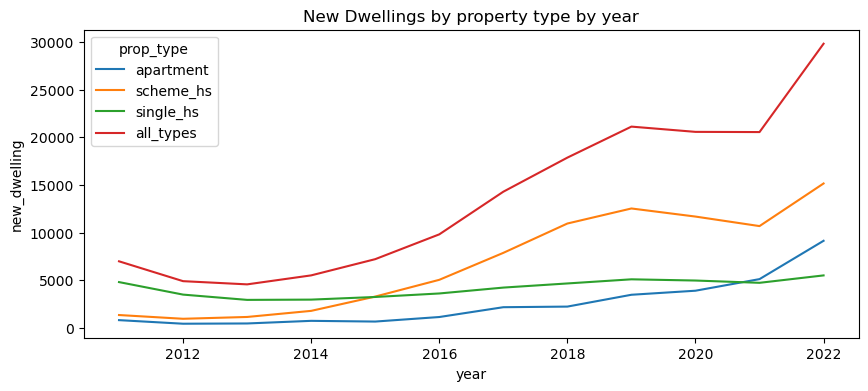

In [4]:
# New Dwellings by property type by year line plot whit manually matching colors on property types
plt.figure(figsize=(10,4))
ax = sns.lineplot(data=nda_df, x='year', y='new_dwelling', hue='prop_type', hue_order=['apartment','scheme_hs','single_hs','all_types']).set(title='New Dwellings by property type by year');

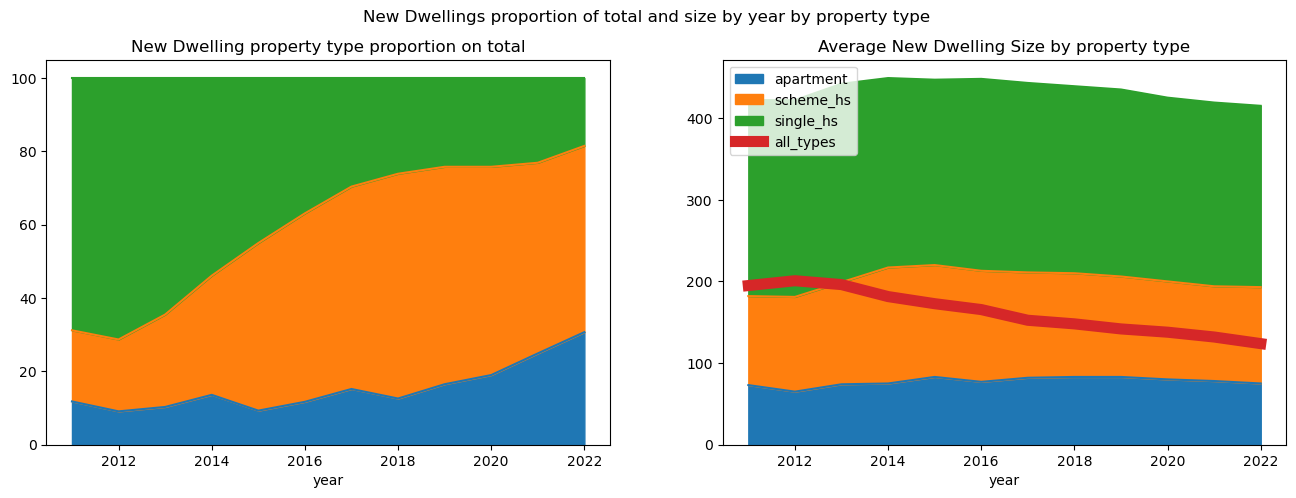

In [5]:
# Dataset for first subplot
nda_df2 = nda_df[nda_df['prop_type']!='all_types']
nda_df2 = nda_df2[['year','prop_type','dwelling_type_perc']]
nda_df2 = nda_df2.pivot_table('dwelling_type_perc','year','prop_type')

# Dataset for second subplot
nda_df3 = nda_df[['year','prop_type','avg_dwelling_size']]
nda_df3 = nda_df3.pivot_table('avg_dwelling_size','year','prop_type')

# Plots
fig, axs = plt.subplots(ncols=2, figsize=(16,5))
fig.suptitle('New Dwellings proportion of total and size by year by property type')
nda_df2.plot.area(legend=False,ax=axs[0])
nda_df3[['apartment','scheme_hs','single_hs']].plot.area(ax=axs[1])
nda_df3[['all_types']].plot.line(lw=8,ax=axs[1])
axs[1].legend(loc='upper left')
axs[0].set_title('New Dwelling property type proportion on total')
axs[1].set_title('Average New Dwelling Size by property type');

In [36]:
nda_df4 = nda_df[(nda_df['year']==2012)|(nda_df['year']==2022)]
nda_df4 = nda_df4[['year','prop_type','new_dwelling']]
nda_df4 = nda_df4.pivot_table('new_dwelling','prop_type','year')
nda_df4.reset_index(inplace=True)
nda_df4['annual_growth_perc'] = round(((nda_df4[2022] / nda_df4[2012])**(1/10)-1)*100,2)
nda_df4

year,prop_type,2012,2022,annual_growth_perc
0,all_types,4911.0,29822.0,19.77
1,apartment,446.0,9147.0,35.27
2,scheme_hs,964.0,15160.0,31.72
3,single_hs,3501.0,5515.0,4.65


### Daft house prices

In [6]:
daft_df = pd.read_csv('daft.csv')
daft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6986 entries, 0 to 6985
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            6986 non-null   float64
 1   floor_area       6986 non-null   float64
 2   beds             6986 non-null   float64
 3   baths            6986 non-null   float64
 4   property_type    6986 non-null   object 
 5   floor_area_unit  6986 non-null   object 
 6   price_sq_mt      6986 non-null   float64
dtypes: float64(5), object(2)
memory usage: 382.2+ KB


In [7]:
daft_df.describe()

,price,floor_area,beds,baths,price_sq_mt
count,6.986000e+03,6986.000000,6986.000000,6986.000000,6986.000000
mean,4.633784e+05,145.896794,3.399227,2.368451,3378.386630
std,5.103132e+05,106.239924,1.225800,1.194332,2025.788828
min,3.000000e+04,10.000000,1.000000,1.000000,40.000000
25%,2.400000e+05,85.000000,3.000000,1.000000,2043.000000
50%,3.450000e+05,120.000000,3.000000,2.000000,2857.000000
75%,5.100000e+05,177.000000,4.000000,3.000000,4293.750000
max,9.850000e+06,2200.000000,9.000000,9.000000,60000.000000


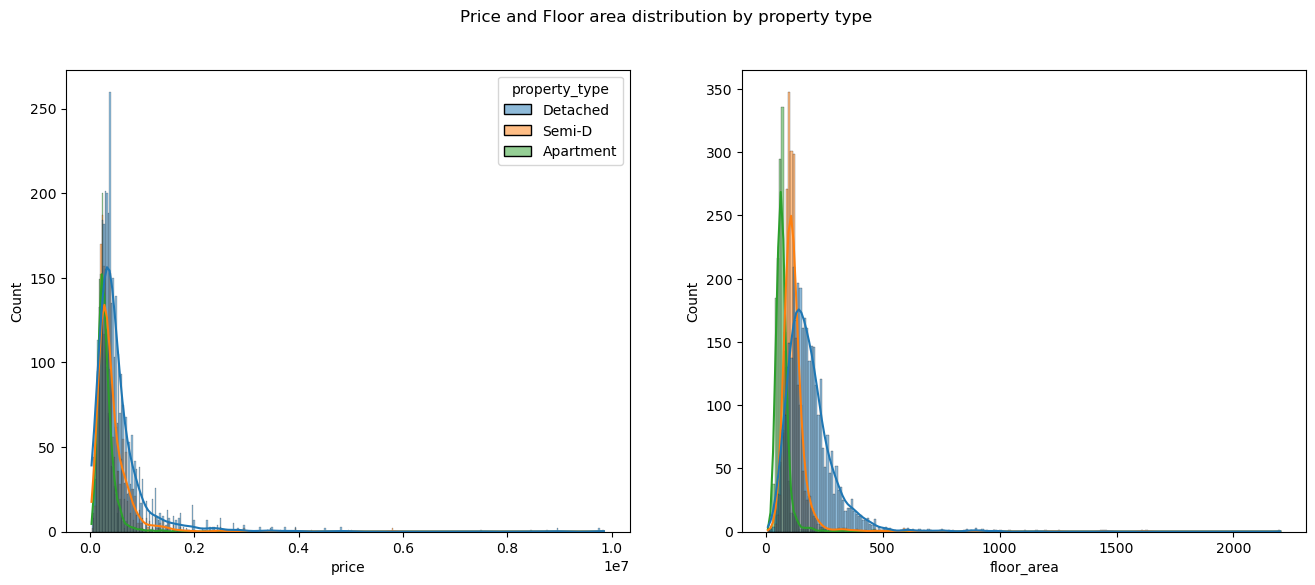

In [8]:
# Price and Floor area distribution by property type plots
fig, axs = plt.subplots(ncols=2, figsize=(16,6))
fig.suptitle('Price and Floor area distribution by property type')
sns.histplot(data=daft_df, x='price', kde=True, hue='property_type', ax=axs[0])
sns.histplot(data=daft_df, x='floor_area', kde=True, hue='property_type', ax=axs[1], legend=None);

In [9]:
daft_df['property_type'].value_counts().sort_index()

Apartment    1443
Detached     3437
Semi-D       2106
Name: property_type, dtype: int64

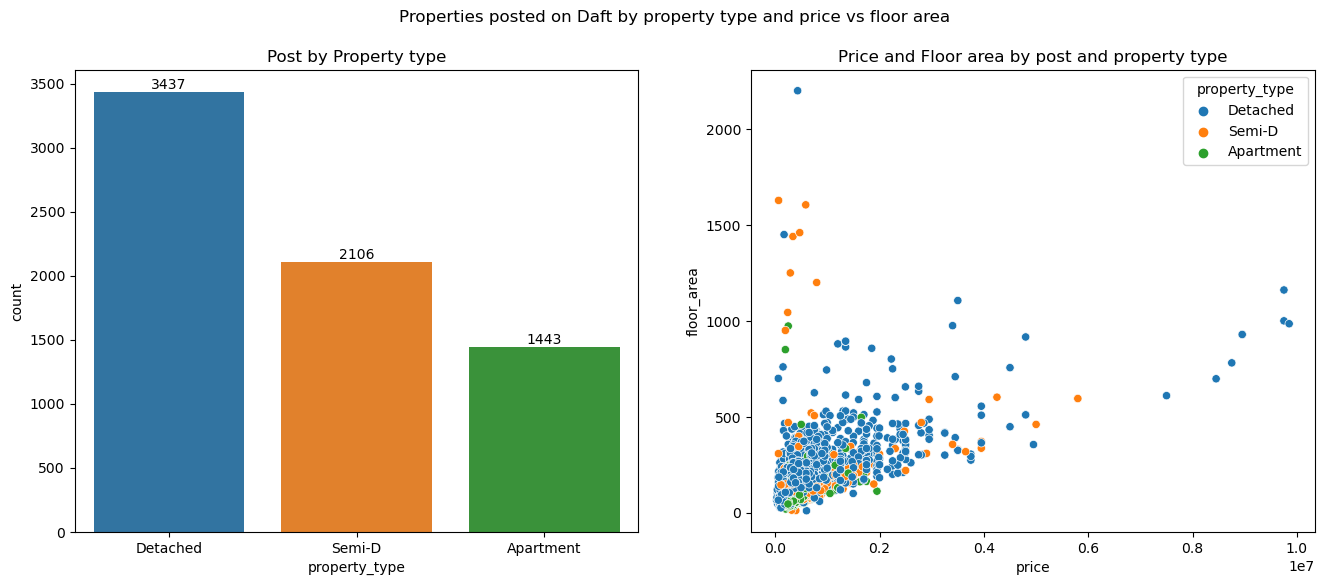

In [10]:
# Properties posted on Daft by property type and price vs floor area plot
fig, axs = plt.subplots(ncols=2, figsize=(16,6))
fig.suptitle('Properties posted on Daft by property type and price vs floor area')
sns.countplot(data=daft_df, x='property_type', ax=axs[0]).bar_label(axs[0].containers[0])
sns.scatterplot(data=daft_df, x='price', y='floor_area',hue='property_type', ax=axs[1])
axs[0].set_title('Post by Property type')
axs[1].set_title('Price and Floor area by post and property type');

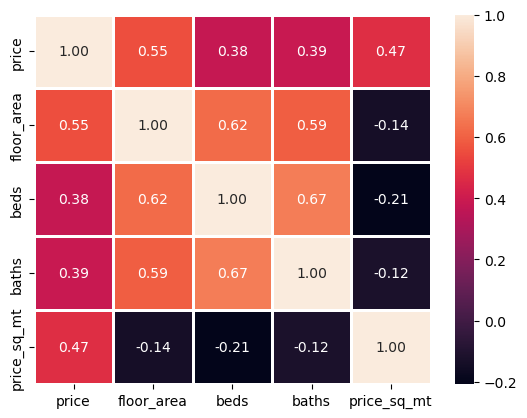

In [11]:
# Correlation between features heatmap
sns.heatmap(daft_df.corr(), annot=True, fmt='.2f', linewidths=2);

In [12]:
# From Daft posted prices and fllor area, claculate possible population mean for both with 95% confidence.

# Prices by type lists
detached_prices = daft_df[daft_df['property_type']=='Detached']['price'].values.tolist()
semid_prices = daft_df[daft_df['property_type']=='Semi-D']['price'].values.tolist()
apartment_prices = daft_df[daft_df['property_type']=='Apartment']['price'].values.tolist()

# Apply t.interval function with 95% confidence and standard error of the mean to price lists.
detached_price_ci = st.t.interval(confidence=0.95, df=len(detached_prices)-1, loc=np.mean(detached_prices), scale=st.sem(detached_prices))
semid_price_ci = st.t.interval(confidence=0.95, df=len(semid_prices)-1, loc=np.mean(semid_prices), scale=st.sem(semid_prices))
apartment_price_ci = st.t.interval(confidence=0.95, df=len(apartment_prices)-1, loc=np.mean(apartment_prices), scale=st.sem(apartment_prices))

# Floor area observations by type lists.
detached_fa = daft_df[daft_df['property_type']=='Detached']['floor_area'].values.tolist()
semid_fa = daft_df[daft_df['property_type']=='Semi-D']['floor_area'].values.tolist()
apartment_fa = daft_df[daft_df['property_type']=='Apartment']['floor_area'].values.tolist()

# Apply t.interval function with 95% confidence and standard error of the mean to price lists.
detached_fa_ci = st.t.interval(confidence=0.95, df=len(detached_fa)-1, loc=np.mean(detached_fa), scale=st.sem(detached_fa))
semid_fa_ci = st.t.interval(confidence=0.95, df=len(semid_fa)-1, loc=np.mean(semid_fa), scale=st.sem(semid_fa))
apartment_fa_ci = st.t.interval(confidence=0.95, df=len(apartment_fa)-1, loc=np.mean(apartment_fa), scale=st.sem(apartment_fa))

# Print results
print(f'Average price and floor area by property type in Irelad with 95% confidence:\n',
      f'\n',
      f'Detached house average price: between €{round(detached_price_ci[0])} and €{round(detached_price_ci[1])}.\n',
      f'Detached house average floor area: between {round(detached_fa_ci[0])} and {round(detached_fa_ci[1])} sqmt.\n',
      f'\n',
      f'Semi Detached house average price: between €{round(semid_price_ci[0])} and €{round(semid_price_ci[1])}.\n',
      f'Semi Detached house average floor area: between {round(semid_fa_ci[0])} and {round(semid_fa_ci[1])} sqmt.\n',
      f'\n',
      f'Apartment average price: between €{round(apartment_price_ci[0])} and €{round(apartment_price_ci[1])}.\n',
      f'Apartment average floor area: between {round(apartment_fa_ci[0])} and {round(apartment_fa_ci[1])} sqmt.')

Average price and floor area by property type in Irelad with 95% confidence:
 
 Detached house average price: between €529192 and €571494.
 Detached house average floor area: between 187 and 194 sqmt.
 
 Semi Detached house average price: between €415276 and €449348.
 Semi Detached house average floor area: between 120 and 128 sqmt.
 
 Apartment average price: between €292528 and €310637.
 Apartment average floor area: between 70 and 75 sqmt.


### Residential Price index 

- month
    - from 2001-01-01 to 2022-12-01
- countries
    - 'AT', 'ES', 'FI', 'IE', 'LT', 'NL', 'NO', 'PL', 'PT'
- residential_price_index:
- perc_change_prev:
- perc_change_yoy:

In [13]:
rpi_df = pd.read_csv('res_price_index.csv', parse_dates=['month'])
rpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2376 entries, 0 to 2375
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   month                    2376 non-null   datetime64[ns]
 1   country                  2376 non-null   object        
 2   residential_price_index  2376 non-null   float64       
 3   perc_change_prev         2376 non-null   float64       
 4   perc_change_yoy          2376 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 92.9+ KB


In [14]:
rpi_df.describe()

,residential_price_index,perc_change_prev,perc_change_yoy
count,2376.000000,2376.000000,2376.000000
mean,95.911490,0.244024,3.015362
std,15.466098,0.662065,4.116842
min,60.100000,-4.200000,-18.200000
25%,84.875000,0.000000,1.000000
50%,98.100000,0.100000,2.400000
75%,103.800000,0.500000,4.100000
max,154.500000,4.500000,23.600000


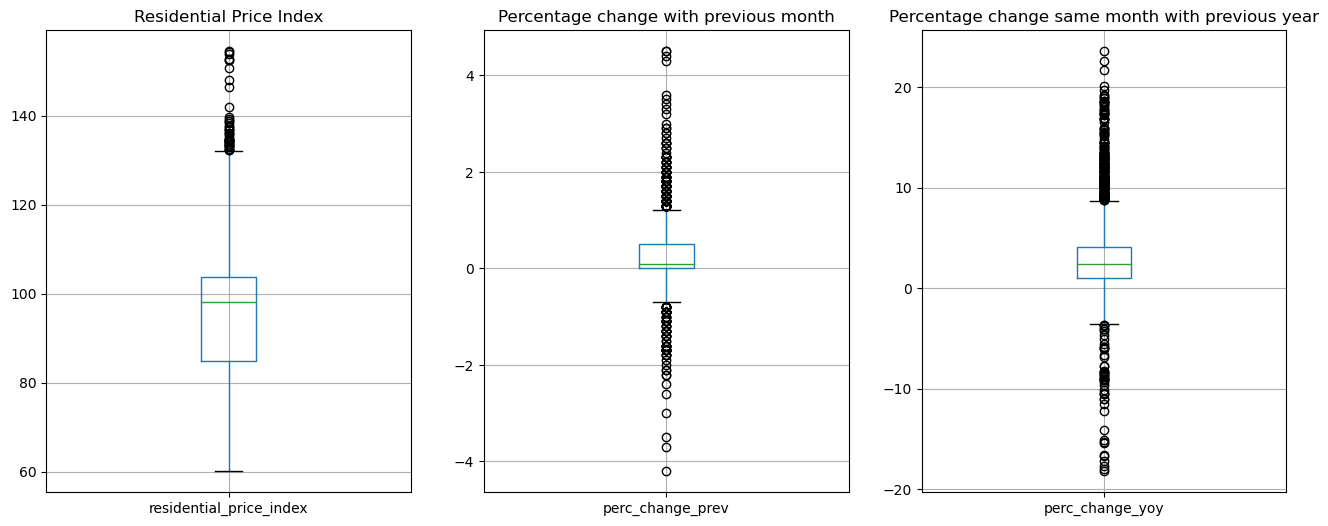

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(16,6))
rpi_df.boxplot(column=['residential_price_index'], ax=axs[0])
rpi_df.boxplot(column=['perc_change_prev'], ax=axs[1])
rpi_df.boxplot(column=['perc_change_yoy'], ax=axs[2])
axs[0].set_title('Residential Price Index')
axs[1].set_title('Percentage change with previous month')
axs[2].set_title('Percentage change same month with previous year');

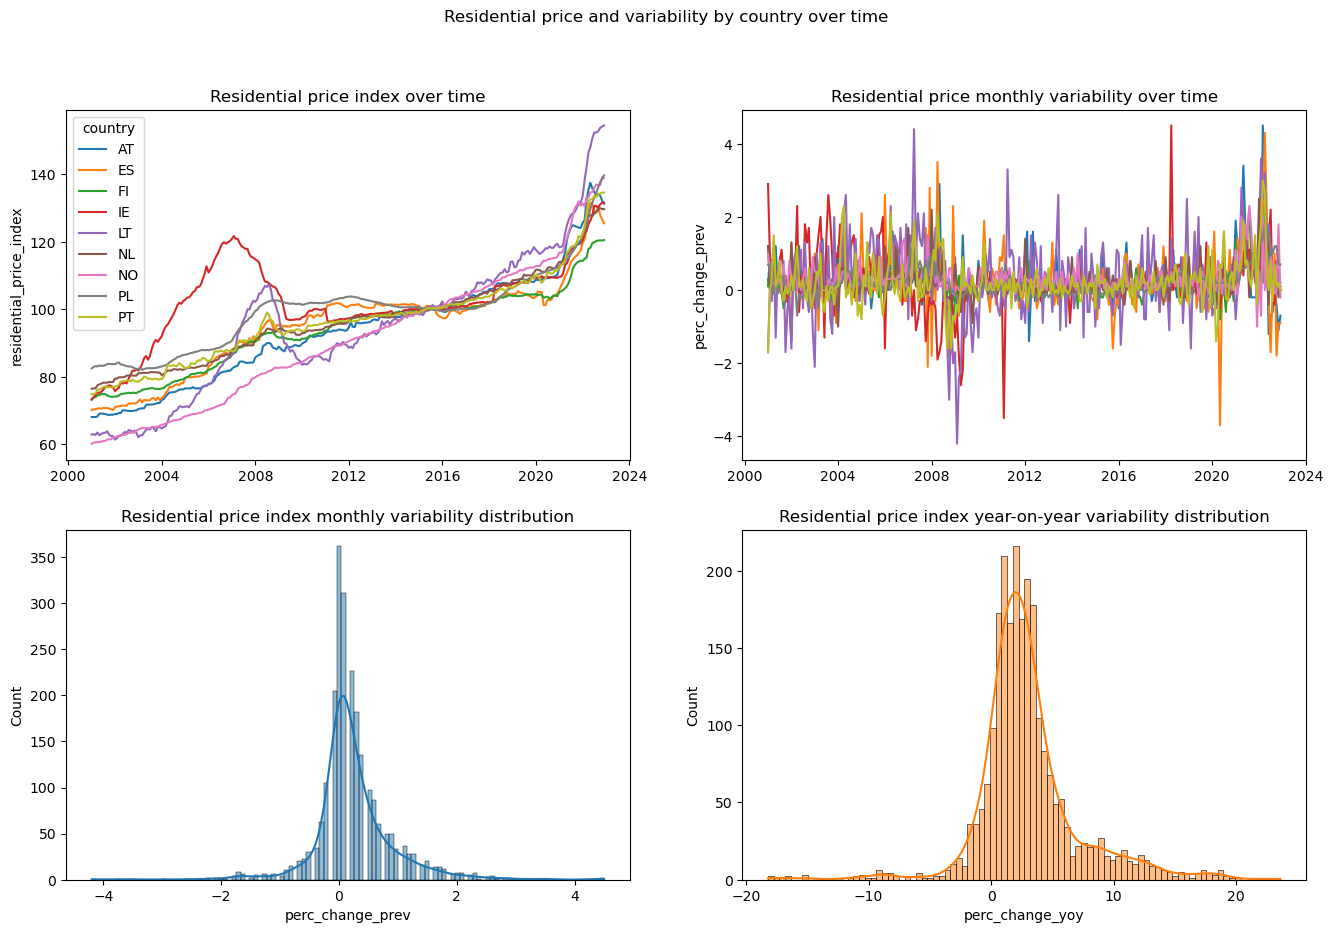

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
fig.suptitle('Residential price and variability by country over time')
sns.lineplot(data=rpi_df, x='month', y='residential_price_index', hue='country', ax=axs[0,0]).set(title='Residential price index over time',xlabel=None)
sns.lineplot(data=rpi_df, x='month', y='perc_change_prev', hue='country', ax=axs[0,1], legend=None).set(title='Residential price monthly variability over time',xlabel=None)

sns.histplot(rpi_df['perc_change_prev'], kde=True, ax=axs[1,0]).set(title='Residential price index monthly variability distribution')
sns.histplot(rpi_df['perc_change_yoy'], kde=True, color='tab:orange', ax=axs[1,1]).set(title='Residential price index year-on-year variability distribution');

In [17]:
positive_months = rpi_df[rpi_df['perc_change_prev']>0][['country','perc_change_prev']].groupby('country').agg(positive_count=('perc_change_prev','count'),
                                                                                                              positive_mean=('perc_change_prev','mean'),
                                                                                                              positive_total=('perc_change_prev','sum'))
negative_months = rpi_df[rpi_df['perc_change_prev']<0][['country','perc_change_prev']].groupby('country').agg(negative_count=('perc_change_prev','count'),
                                                                                                              negative_mean=('perc_change_prev','mean'),
                                                                                                              negative_total=('perc_change_prev','sum'))
neutral_months = rpi_df[rpi_df['perc_change_prev']==0][['country','perc_change_prev']].groupby('country').agg(neutral_count=('perc_change_prev','count'))
total_months = rpi_df[['country','perc_change_prev']].groupby('country').agg(total_count=('perc_change_prev','count'),
                                                                             total_mean=('perc_change_prev','mean'),
                                                                             total_total=('perc_change_prev','sum'))
grouped_df = pd.concat([positive_months, negative_months,neutral_months,total_months], axis=1)
grouped_df

,positive_count,positive_mean,positive_total,negative_count,negative_mean,negative_total,neutral_count,total_count,total_mean,total_total
country,,,,,,,,,,
AT,138,0.615942,85.0,66,-0.283333,-18.7,60,264,0.251136,66.3
ES,139,0.718705,99.9,86,-0.458140,-39.4,39,264,0.229167,60.5
FI,170,0.362941,61.7,51,-0.233333,-11.9,43,264,0.188636,49.8
IE,156,0.656410,102.4,67,-0.598507,-40.1,41,264,0.235985,62.3
LT,169,0.952071,160.9,88,-0.803409,-70.7,7,264,0.341667,90.2
NL,147,0.441497,64.9,47,-0.217021,-10.2,70,264,0.207197,54.7
NO,213,0.413146,88.0,13,-0.238462,-3.1,38,264,0.321591,84.9
PL,165,0.385455,63.6,67,-0.147761,-9.9,32,264,0.203409,53.7
PT,156,0.551923,86.1,76,-0.377632,-28.7,32,264,0.217424,57.4


## Hypothesis Tests

### Shapiro-Wilk

- H(0): The monthly residential price variability with previous month is normally distributed.
- H(1): The monthly residential price variability with previous month is not normally distributed.

ShapiroResult(statistic=0.8675892353057861, pvalue=6.473578515641357e-41)


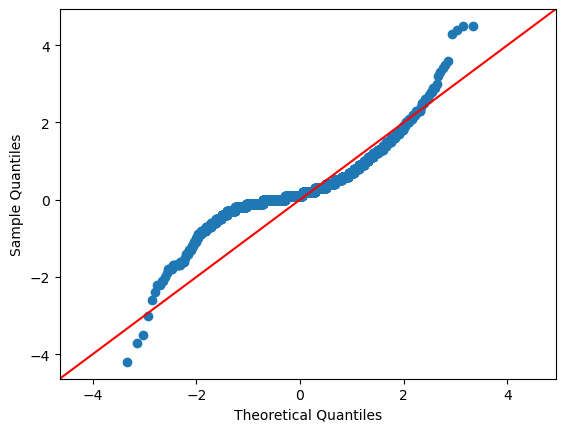

In [18]:
# Shapiro-Wilk test
print(shapiro(rpi_df['perc_change_prev'].values))

# Q-Q plot to double check visually
fig = sm.qqplot(rpi_df['perc_change_prev'].values, line='45')

H(0) rejected, therefore H1 accepted. The sample has not been generated from a normal distribution.

Continue with non-parametric tests

### Kruskas-Wallis

- H(0): there is no difference in the recidential price monthly variability between countries.
- H(1): at least one of the countries draws differences in the recidential price monthly variability

In [19]:
# Including all countries
kruskal(data=rpi_df, dv='perc_change_prev', between='country')

,Source,ddof1,H,p-unc
Kruskal,country,8,41.093923,0.000002


Test including all countries: p-value < 0.05, H(0) is rejected so H(1) accepted.

As H1 was accepted, therefore at least one of the countries median is different (p-value=0.05) to the others, in order to identify which country is causing this result the test is repeated excluding only one country on each loop untill all combinations are tested. 

In [20]:
countries = rpi_df['country'].unique().tolist()
result_dict = {'countries_tested':[],'removed_country':[],'pvalue':[]}

for country in countries:
    countries_tested = [n for n in countries if n != country]
    kruskal_result_df = kruskal(data=rpi_df[rpi_df['country']!=country], dv='perc_change_prev', between='country')
    pvalue = kruskal_result_df['p-unc'].values
    result_dict['countries_tested'].append(countries_tested)
    result_dict['removed_country'].append(country)
    result_dict['pvalue'].append(round(pvalue[0],6))

kruskal_df = pd.DataFrame.from_dict(result_dict) 
kruskal_df

,countries_tested,removed_country,pvalue
0,"[ES, FI, IE, LT, NL, NO, PL, PT]",AT,0.000002
1,"[AT, FI, IE, LT, NL, NO, PL, PT]",ES,0.000001
2,"[AT, ES, IE, LT, NL, NO, PL, PT]",FI,0.000003
3,"[AT, ES, FI, LT, NL, NO, PL, PT]",IE,0.000001
4,"[AT, ES, FI, IE, NL, NO, PL, PT]",LT,0.000005
5,"[AT, ES, FI, IE, LT, NO, PL, PT]",NL,0.000005
6,"[AT, ES, FI, IE, LT, NL, PL, PT]",NO,0.090556
7,"[AT, ES, FI, IE, LT, NL, NO, PT]",PL,0.000003
8,"[AT, ES, FI, IE, LT, NL, NO, PL]",PT,0.000001


The only test where H0 is accepted is removing Norway from the list of countries.

### U-Mann Whitman test

Ireland vs Each country
- H0: There is no difference in the residential price monthly variability between Ireland and x (accepted for all but Norway)
- H1: There is difference in the residential price monthly variability between Ireland and x (rejected for all but Norway)

In [21]:
countries = rpi_df['country'].unique().tolist()
countries.remove('IE')

result_dict = {'country':[],'pvalue':[]}
for country in countries:
    statistic, pvalue = mannwhitneyu(rpi_df[rpi_df['country']=='IE']['perc_change_prev'],rpi_df[rpi_df['country']==country]['perc_change_prev'])
    result_dict['country'].append(country)
    result_dict['pvalue'].append(pvalue)

mannwhitney_df = pd.DataFrame.from_dict(result_dict) 
mannwhitney_df

,country,pvalue
0,AT,0.505257
1,ES,0.395557
2,FI,0.925292
3,LT,0.050527
4,NL,0.518997
5,NO,0.000550
6,PL,0.858023
7,PT,0.618668


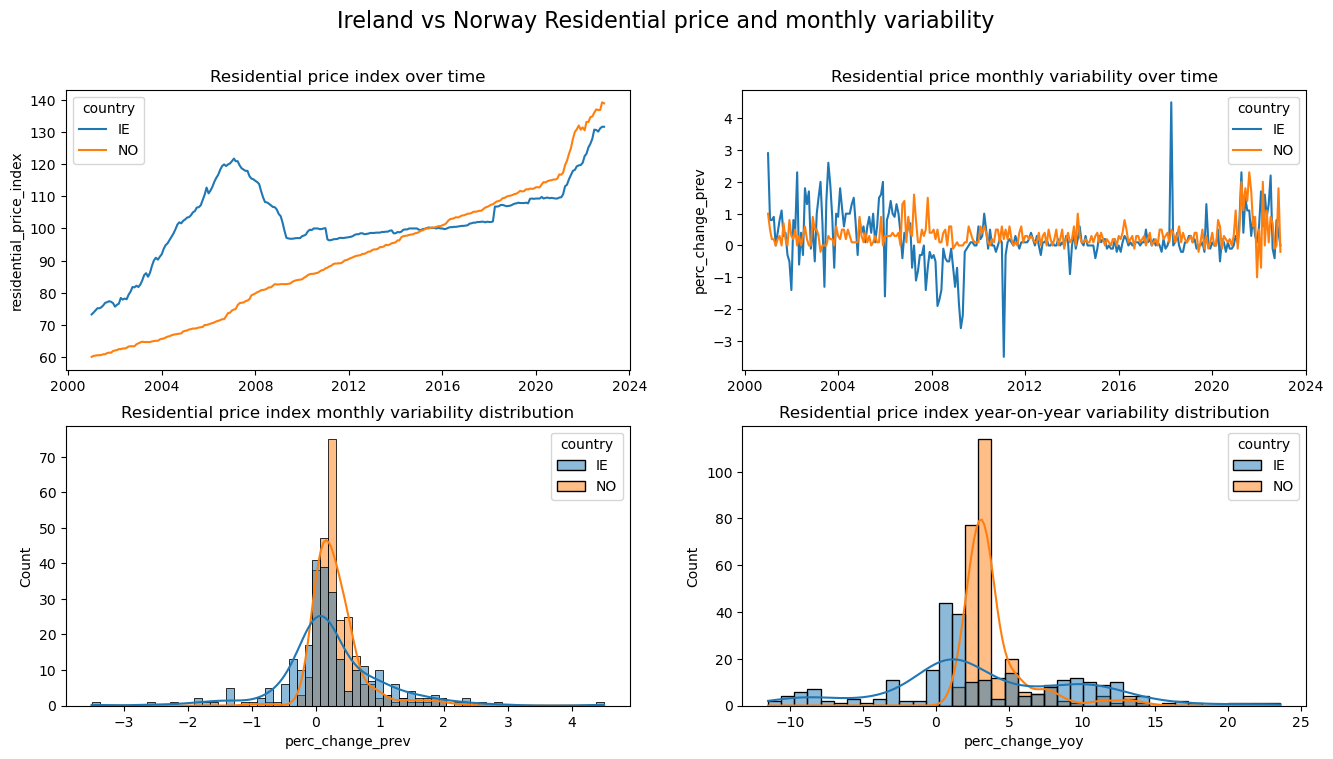

In [22]:
# Plot Norway vs Ireland to compare 

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
fig.suptitle('Ireland vs Norway Residential price and monthly variability', fontsize=16)
sns.lineplot(data=rpi_df[(rpi_df['country']=='NO')|(rpi_df['country']=='IE')], x='month', y='residential_price_index', hue='country', ax=axs[0,0]).set(title='Residential price index over time',xlabel=None)
sns.lineplot(data=rpi_df[(rpi_df['country']=='NO')|(rpi_df['country']=='IE')], x='month', y='perc_change_prev', hue='country', ax=axs[0,1]).set(title='Residential price monthly variability over time',xlabel=None)
sns.histplot(data=rpi_df[(rpi_df['country']=='NO')|(rpi_df['country']=='IE')], x='perc_change_prev', hue='country', kde=True, ax=axs[1,0]).set(title='Residential price index monthly variability distribution')
sns.histplot(data=rpi_df[(rpi_df['country']=='NO')|(rpi_df['country']=='IE')], x='perc_change_yoy', hue='country', kde=True, ax=axs[1,1]).set(title='Residential price index year-on-year variability distribution');

In [23]:
NO_a = len(rpi_df[rpi_df['country']=='NO'])
NO_b = len(rpi_df[(rpi_df['country']=='NO')&(rpi_df['perc_change_prev']>=0)&(rpi_df['perc_change_prev']<=1)])
NO_c = len(rpi_df[(rpi_df['country']=='NO')&(rpi_df['perc_change_prev']<0)])
NO_0to1 = round(NO_b/NO_a*100)
NO_less0 = round(NO_c/NO_a,2)

IE_a = len(rpi_df[rpi_df['country']=='IE'])
IE_b = len(rpi_df[(rpi_df['country']=='IE')&(rpi_df['perc_change_prev']>=0)&(rpi_df['perc_change_prev']<=1)])
IE_c = len(rpi_df[(rpi_df['country']=='IE')&(rpi_df['perc_change_prev']<0)])
IE_0to1 = round(IE_b/IE_a*100)
IE_less0 = round(IE_c/IE_a*100)

# a = all records
# b = perc_change_prev between 0 and 1

print(f'Norway monthly price variability between 0% and 1% explains {NO_0to1}% of all variability while for Ireland is only {IE_0to1}%')
print(f'Negatives (less tan 0) Ireland monthly price variability explains {IE_less0}% of all variability while for Norway is only {NO_less0}%')

Norway monthly price variability between 0% and 1% explains 90% of all variability while for Ireland is only 63%
Negatives (less tan 0) Ireland monthly price variability explains 25% of all variability while for Norway is only 0.05%


Monthly and year-on-year variability distribution for Norway is more concentrated on the positive side compared to Ireland's distribution. Previous test suggested at a 95% of confidence level that there is no difference between Ireland and the rest therefore we can conclude that Norway is the only different country from the sample.